# <font color=green>Introduction to G-KPFM simulations</font>

#### Content under Creative Commons Attribution license CC-BY 4.0 version, 
## Author: Liam Collins
## Date: August 18th 2018
## Simulations for SPMonSPM2018 (Leuven)
The Analytic method ( Runge Kutta 4 [RK4] (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method for the solution of ODEs) used to simulate the cantilever dynamics under voltage modulation were based on a Jupyter Notebook developed by Enrique A. López-Guerra which can be found here. [Introduction to dynamic AFM simulations](https://github.com/pycroscopy/pycroscopy/tree/master/jupyter_notebooks/AFM_simulations)

### <font color=green> Purpose of the notebook: description of operation of G-KPFM using modelled data</font>

*Requirements*:<br>
<br>
1. Knowledge on the  the fundamentals of  [Harmonic Oscillators](http://en.wikipedia.org/wiki/Harmonic_oscillsator) in clasical mechanics and [Fundamentals of Vibrations](http://en.wikipedia.org/wiki/Vibration). <br>
2. If you prefer, and are new to AFM, useful video lecture series by Arvind Raman can be found here: [Harmonic Oscillators](https://nanohub.org/courses/afm1)

First lets import all approriate packages used in this analysis.

In [33]:
##Install some packages and setup notebook
from __future__ import division, print_function, absolute_import, unicode_literals
import os
import numpy as np
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from scipy import signal
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
                                                

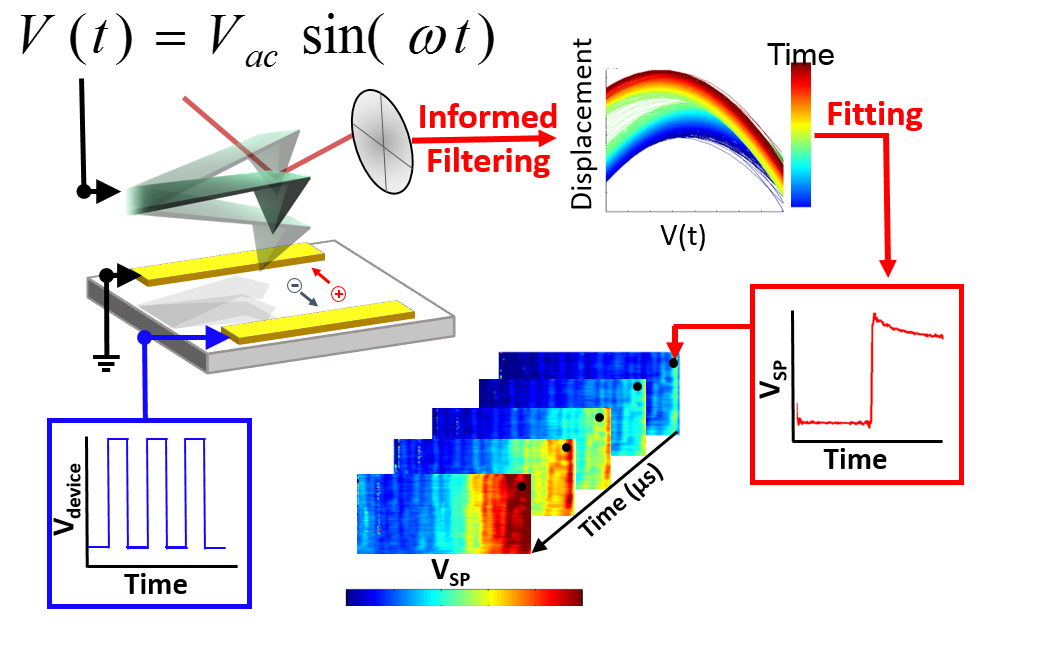

In [34]:
path = os.getcwd()
fig1 = path + '/Figures/Figure 1 GKPFM.png'
Image(filename=fig1)

We would like to describe the cantilever motion in G-KPFM. For simplicity we consider a tip free from the surface (i.e. lift mode) with the application of an AC voltage between probe and sample. We will focus on the case of small amplitude (i.e. delta(y)<< y0). In future, we should consider the case where we have large oscillation amplitudes (i.e. delta(y)~y0) in which we will need to consider short range interactions, as well as the fact that dC/dz will vary non-linear as a function of tip position. In general, the former can describe lift mode operation, whereas the latter will be needed to describe single pass KPFM/EFM.

The motion of the AFM probe can be described using the [Euler-Bernoulli's] (http://en.wikipedia.org/wiki/Euler%E2%80%93Bernoulli_beam_theory)  equation (see figure below). Notice that the EB equation has partial derivatives (it depends on time and space) because it deals with finding the position of each point of the beam in a certain time, which cant make the problem too expensive computationally for our purposes. 

As a consequence, approximations using a simple mass point model approximation [see ref. 2] like the one in figure 2 (with of course the addition of tip sample forces!  We will see more about this later).


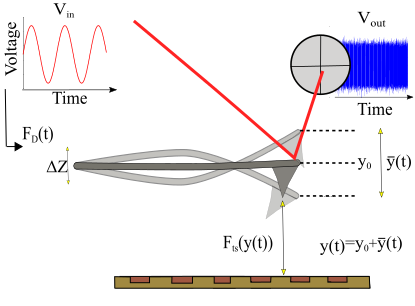

In [35]:
path = os.getcwd()
fig1 = path + '/Figures/Figure 2.png'
Image(filename=fig1)

Where *y* is the tip displacement (with dots representing the time derivatives), *$ω_{n}$* and *$k_{n}$* are the resonant frequency and spring constants, of the *$n_{th}$* cantilever eigenmode. *Q* is the dimensionless quality factor, which provides a measure of how fast the cantilever oscillation responds to a sudden perturbation, and defines the mechanical bandwidth of the cantilever which can be
approximated as *$ω_{o}$*/ *Q*. *Q* is the dimensionless quality factor, which provides a measure of how fast the cantilever oscillation responds to a sudden perturbation, and defines the mechanical bandwidth of the cantilever (*∆ω*) which can be approximated as *$ω_{n}$/Q*. 

Equivalently, the impulse response of the cantilever with a steady state amplitude $A_{0}$ is given by an exponential function ($A_{0}$ e^(-t⁄$t_{ringdown}$)) where ringdown time constant (*$t_{ringdown}$*) is on the order of *Q/π$ω_{0}$*.  Traditionally, these parameters are assumed to impose a fundamental limit on the time resolution of any AFM measurement. Under these criteria, for a cantilever having parameters of *$ω_{0}$*= 60 kHz, *Q* = 150, *∆ω* ≈ 400 Hz and $t_{ringdown}$≈ 0.796 ms meaning it will take ~2.2 ms for the cantilever to equilibrate to steady state after an initial forcing impulse. Note that the constants *$ω_{n}$*  and *$Q_{n}$* can be easily measured from cantilever thermal noise spectrum, while calibration of *$k_{n}$* for higher eigenmodes (>1) requires some additional considerations.


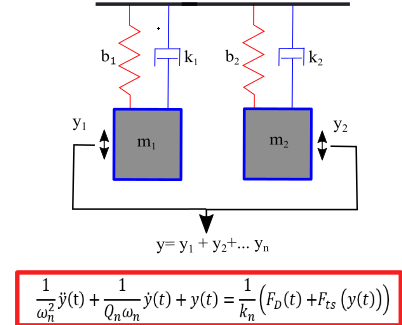

In [36]:
path = os.getcwd()
fig2 = path + '/Figures/Figure 3.png'
Image(filename=fig2)



On the right hand side of the EB equation, two terms representing the time-dependent driving force, *$F_{D}$*, and the non-linear tip sample interaction force, *$F_{ts}$*, are included. As has been mentioned previously, in the case of capacitive actuation, the driving force and tip-sample interaction force coincide.

In G-KPFM, a periodic AC input voltage (V$_{in}$(cos(ωt))), is used to induce a cantilever motion, ∆y(t), through the application of an electrostatic driving force (F$_{es}$) applied to the tip in the form of an electrostatic force between tip and sample. The force can be split into spectrial components as follows:


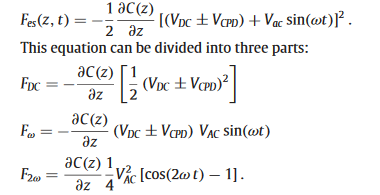

In [37]:
path = os.getcwd()
fig2 = path + '/Figures/Figure 4.png'
Image(filename=fig2)

Approximations for the Capacitive Force were developed by Hudlet et al, [paper](https://link.springer.com/article/10.1007/s100510050219) and described as:

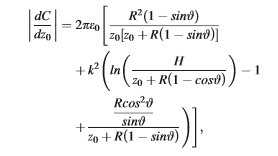

In [38]:
path = os.getcwd()
fig2 = path + '/Figures/Equation 1 Hudlet.png'
Image(filename=fig2)

Ok, so now we have an equation of motion to describe the cantilever / probe motion. We also have approximations for the electrostatic driving force provided we can paramters describing the geometry of the probe (e.g. cone angle, radius, cone height etc.). First lets set up the problem.


In [2]:
# Simulations and Cantilever Parameters
IO_rate=2E6
dt =1.0/IO_rate
N = 2**18 ##Full Simulation time
N2 = 2**16 ##Steady state time

fs = np.arange(-IO_rate/2., IO_rate/2., IO_rate/N)
simultime = N*dt # Simulation time 
t = numpy.linspace(0,simultime,N) # time vector 

# Cantilever constants
fo_req = 60000 #Frequecy Hertz Hz
fo_ind = np.nonzero(np.abs(fo_req-fs) == np.min(np.abs(fo_req-fs)))[0][0]
fo = fs[fo_ind]  ##********************* This is to avoid fourier leakage ********
period_cant = 1./fo ##period of cantilever oscillation

wo = 2*np.pi*fo #Angular frequency

k = 2.8#Spring Constant
Q = 180 #Quality factor
m = k/(wo**2) #Mass 

print('Requested Cantilever resonance frequency was {} Khz'.format(fo_req/1000.) + ' Closest frequency value {} Khz'.format(fo/1000))

print('Estimated Cantilever Ringdown {} ms'.format((Q/(np.pi*fo/1000.))))
print('Estimated Cantilever Bandwidth {} Hz'.format((fo/Q)))

NameError: name 'np' is not defined

Requested frequency of AC voltage was 59.99755859375 KHz  Closest frequency value 59.99755859375 Khz
Number of periods per simulation 7864.0 
Points per period 33.33468972533062 


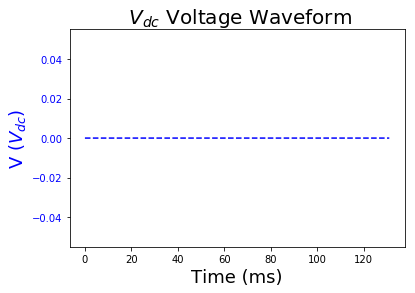

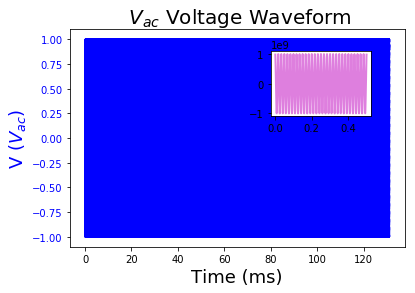

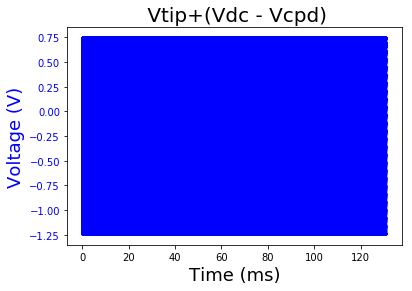

In [40]:
# Simulate Excitation Waveforms 

V_ac=1
Vcpd=0.25
Vdc=0
Vdc_vec = numpy.zeros(N) # Sample Bias array
Vac_vec = numpy.zeros(N)# AC Voltage array
Vtip = numpy.zeros(N)# AC + DC Voltage array

Vac_f_req=fo #Vac Frequency

###Find closest frequency bin to avoid fourier leakage
Vacf = np.nonzero(np.abs(Vac_f_req-fs) == np.min(np.abs(Vac_f_req-fs)))[0][0]
f_vac = fs[Vacf]
w_vac  = 2*np.pi*f_vac  #Angular frequency

period = 1./f_vac ##period of drive oscillation
num_periods=simultime/period # time steps per period 
pnts_p_period=N/num_periods


print('Requested frequency of AC voltage was {} KHz'.format(Vac_f_req/1000) + '  Closest frequency value {} Khz'.format(f_vac/1000))


Vac_vec=V_ac*np.cos(2*np.pi*f_vac*t)

vfo_req = 10 #Vdc pulse Frequency
fo_ind = np.nonzero(np.abs(vfo_req-fs) == np.min(np.abs(vfo_req-fs)))[0][0]
f_vdc = fs[fo_ind]
Vdc_vec=Vdc/2*(signal.square(2*np.pi*f_vdc*t)+1)



print('Number of periods per simulation {} '.format((num_periods)))
print('Points per period {} '.format((pnts_p_period)))

fig, ax1 = plt.subplots()
plt.title(' $V_{dc}$ Voltage Waveform', fontsize=20)

ax1.tick_params(axis='y', labelcolor='b')
plt.xlabel('Time (ms)', fontsize=18)
plt.ylabel('V ($V_{dc}$)',fontsize=18,color='b')
plt.plot(t*1e3, Vdc_vec, 'b--')

fig, ax1 = plt.subplots()
plt.title(' $V_{ac}$ Voltage Waveform', fontsize=20)
ax1.set_xlabel('Time (ms)', fontsize=18)
ax1.set_ylabel('V ($V_{ac}$)', fontsize=18,color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.plot(t*1e3, Vac_vec, 'b--')
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.6,0.6,0.3,0.3])
ax2.set_axes_locator(ip)
ax2.plot(t[1:1000]*1e3, Vac_vec[1:1000]*1e9, c='m', lw=2, alpha=0.5)

Vtip[:]=Vac_vec[:]+(Vdc_vec[:]-Vcpd)

fig, ax1 = plt.subplots()
plt.title(' Vtip+(Vdc - Vcpd)', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Time (ms)', fontsize=18)
ax1.set_ylabel('Voltage (V)',fontsize=18,color='b')
ax1.plot(t*1e3, Vtip, 'b--')

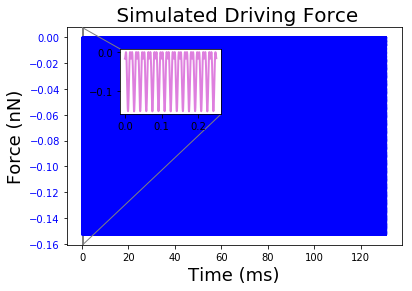

In [41]:
##Simulate a capactive drive force

def make_Fes(z_lift, Vvec, VCPD):
    """
        make_Fes generates the Capacitive driving force

        The Capacitive follows Eq.2 in [1].

       [2] Hudlet reference here
    """
    c_angle=32*np.pi/180
    Rtip= 30e-9
    Height=22e-6
    epislon_z= 8.85e-12; 
    
       
    """ Hudlet approximation of capacitive force taken from equation 13 in Chisea """
    k=1/(np.log(np.tan(c_angle/2)))**2
    a_const = Rtip**2*(1-np.sin(c_angle))/(z_lift*(z_lift+Rtip*(1-np.sin(c_angle))))
    b_const = Height/(z_lift+Rtip*(1-np.cos(c_angle)))
    c_const = (Rtip*np.cos(c_angle)**2/np.sin(c_angle))/(z_lift+Rtip*(1-np.sin(c_angle)))
    Cgrad_lift=2*np.pi*epislon_z*(a_const+k**2*(np.log(b_const)-1+c_const))
    dCdz =np.abs(Cgrad_lift)
    V = Vvec-VCPD
    R = (-1.0/2)*dCdz*V**2
    
    return R, dCdz
    print("Generated Modelled Data")

z_lift=50e-9
Fd = numpy.zeros(N) # Force array

Fd, dCdz = make_Fes(z_lift, Vtip, Vcpd)


fig, ax1 = plt.subplots()
plt.title(' Simulated Driving Force', fontsize=20)
ax1.set_xlabel('Time (ms)', fontsize=18)
ax1.set_ylabel('Force (nN)', fontsize=18)
ax1.tick_params(axis='y', labelcolor='b')
ax1.plot(t*1e3, Fd*1e9, 'b--')
ax2 = plt.axes([1,0,1,1])
ip = InsetPosition(ax1, [0.16,0.6,0.3,0.3])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
ax2.plot(t[0:500]*1e3, Fd[0:500]*1e9, c='m', lw=2, alpha=0.5)



### Let's use now one of the most popular schemes...     The Runge Kutta 4!

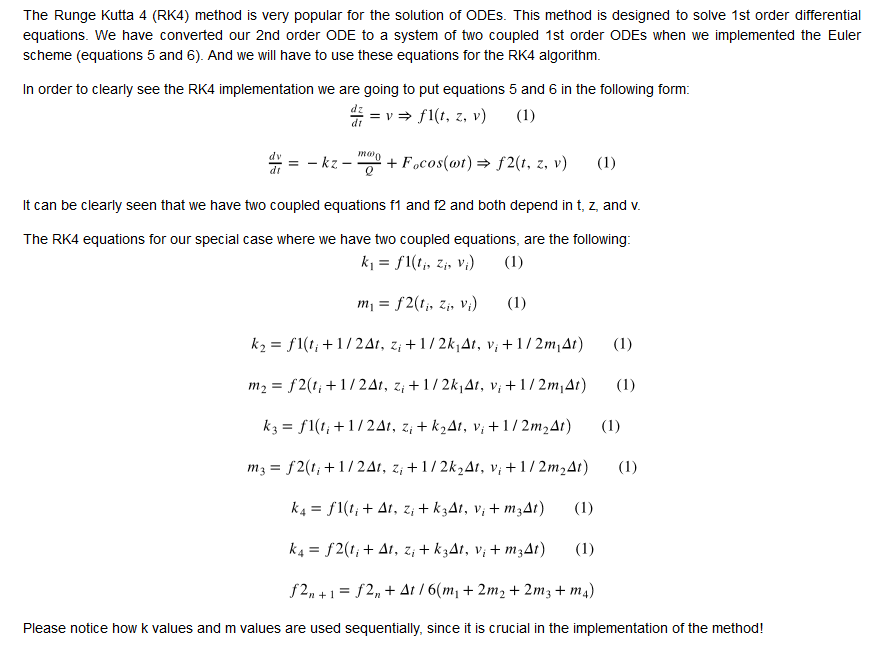

In [42]:
path = os.getcwd()
fig2 = path + '/Figures/Figure 5.png'
Image(filename=fig2)

**Below is the function defined to solve the ODE, notice we do not have a Tip-sample force as in the case of EFM this converges to the driving force**

In [43]:
#Below is the function used to solve the ODE

def run_RK4():
    #IMPORTANT distance where you place the probe above the sample
    z_base =z_lift

    TipPos = numpy.zeros(N)
    Fts = numpy.zeros(N)
    Fcos = numpy.zeros(N)

    #Initializing variables for RK4
    v_RK4 = numpy.zeros(N)
    z_RK4 = numpy.zeros(N)
    k1v_RK4 = numpy.zeros(N) 
    k2v_RK4 = numpy.zeros(N)
    k3v_RK4 = numpy.zeros(N)
    k4v_RK4 = numpy.zeros(N)

    k1z_RK4 = numpy.zeros(N)
    k2z_RK4 = numpy.zeros(N)
    k3z_RK4 = numpy.zeros(N)
    k4z_RK4 = numpy.zeros(N)
    #calculation of velocities RK4

    #INITIAL CONDITIONS
    v_RK4[0] = 0
    z_RK4[0] = 0

    Fts=numpy.zeros(N)

    #Fts = np.zeros(N)
    for i in range(1,N):
       #RK4
        k1z_RK4[i] = v_RK4[i-1]   #k1 Equation 14 
        k1v_RK4[i] = ((   ( -k*z_RK4[i-1] - (m*wo/Q)*v_RK4[i-1] + \
                           -(1.0/2)*dCdz*((Vdc_vec[i-1]-Vcpd)+V_ac*np.cos(w_vac*t[i-1]))**2 )  ) / m )   #m1 Equation 15

        k2z_RK4[i] = ((v_RK4[i-1])+k1v_RK4[i]/2.*dt) #k2 Equation 16
        k2v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k1z_RK4[i]/2.*dt) - (m*wo/Q)*\
                           (v_RK4[i-1] +k1v_RK4[i]/2.*dt) +\
                           -(1.0/2)*dCdz*((Vdc_vec[i-1]-Vcpd)+V_ac*np.cos(w_vac*(t[i-1] + dt/2.)))**2 )  ) / m )  #m2 Eq 17

        k3z_RK4[i] = ((v_RK4[i-1])+k2v_RK4[i]/2.*dt) #k3, Equation 18
        k3v_RK4[i] = ((   ( -k*(z_RK4[i-1]+ k2z_RK4[i]/2.*dt) - (m*wo/Q)*\
                            (v_RK4[i-1] +k2v_RK4[i]/2.*dt) +\
                           -(1.0/2)*dCdz*((Vdc_vec[i-1]-Vcpd)+V_ac*np.cos(w_vac*(t[i-1] + dt/2.)))**2 )  ) / m ) #m3, Eq19

        k4z_RK4[i] = ((v_RK4[i-1])+k3v_RK4[i]*dt) #k4, Equation 20
        k4v_RK4[i] = ((   ( -k*(z_RK4[i-1] + k3z_RK4[i]*dt) - (m*wo/Q)*\
                           (v_RK4[i-1] + k3v_RK4[i]*dt) + 
                           -(1.0/2)*dCdz*((Vdc_vec[i-1]-Vcpd)+V_ac*np.cos(w_vac*(t[i-1]+dt)))**2  )  ) / m )#m4, Eq 21

        #Calculation of velocity, Equation 23
        v_RK4[i] = v_RK4[i-1] + 1./6*dt*(k1v_RK4[i] + 2.*k2v_RK4[i] +\
                        2.*k3v_RK4[i] + k4v_RK4[i] )   
        #calculation of position, Equation 22
        z_RK4 [i] = z_RK4[i-1] + 1./6*dt*(k1z_RK4[i] + 2.*k2z_RK4[i] +\
                         2.*k3z_RK4[i] + k4z_RK4[i] ) 

        TipPos[i] = z_base + z_RK4[i] #Adding base position to z position
       
    return TipPos
    print("Finished Simulation")

<Figure size 432x288 with 0 Axes>

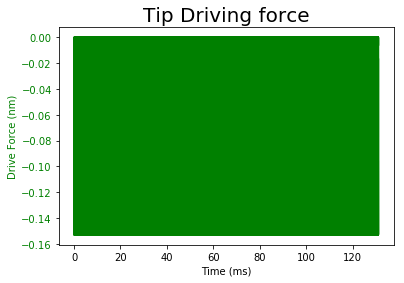

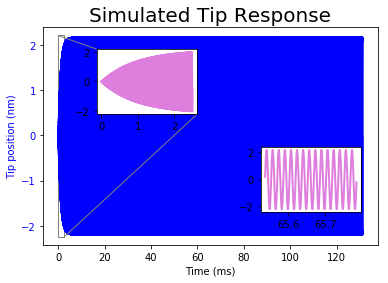

In [44]:
#Some Plotting
TipPos=run_RK4()

#Drive Force 
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(t*1e3,Fd*1e9, 'g-')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Drive Force (nm)', color='g')
plt.title('Tip Driving force', fontsize = 20)
ax1.tick_params(axis='y', labelcolor='g')

#Tip Position 
plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(t[2:]*1e3,(TipPos[2:]-z_lift)*1e9, 'b-')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Tip position (nm)', color='b')
plt.title('Simulated Tip Response', fontsize = 20)
ax2 = plt.axes([1,0,1,1])
ip = InsetPosition(ax1, [0.16,0.6,0.3,0.3])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
ax2.plot(t[1:5000]*1e3,(TipPos[1:5000]-z_lift)*1e9, c='m', lw=2, alpha=0.5)
ax2 = plt.axes([0,0,1,1])
ip2 = InsetPosition(ax1, [0.65,0.15,0.3,0.3])

ax2.set_axes_locator(ip2)

ax2.plot(t[int(N/2):int(N/2+500)]*1e3,(TipPos[int(N/2):int(N/2+500)]-z_lift)*1e9, c='m', lw=2, alpha=0.5)


**Notice the difference in response of the cantielver with respect to the tip driving force. This is a result of the cantilever finite bandwith. It looks like it takes a few milliseconds to reach steady state after we begin to excite the cantilever**

Text(0,0.5,'Displacement')

<Figure size 432x288 with 0 Axes>

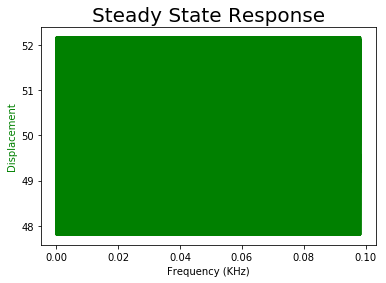

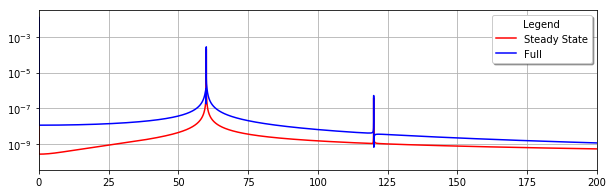

In [48]:

#Slicing arrays to get steady state
n=350
TipPos_steady = TipPos[(N2-1):-1] 
t_steady = t[(N2-1):-1]- t[(N2-1)]   
v_steady = Vtip[(N2-1):-1]  

N3=N-N2
N3

#N2=len(t_new)
New_IO_rate=N3/t_steady[-1]
Fs_steady=np.arange(-New_IO_rate/2., New_IO_rate/2., New_IO_rate/N3)



plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(t_steady,TipPos_steady*1e9, 'g-')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Tip position (nm)', color='g')
plt.title('Steady State Response', fontsize = 20)

fig= plt.figure(num=3,figsize=(10,10))
plt.subplot(311)
TipPos[0]=TipPos[1]
F_R = np.fft.fftshift(np.fft.fft(TipPos_steady)) #axis=0 not necessary
plt.semilogy(Fs_steady/1000,abs(F_R), color='red', markersize=10,label='Steady State')

F_R = np.fft.fftshift(np.fft.fft(TipPos)) #axis=0 not necessary
plt.semilogy(fs/1000,abs(F_R), color='blue', markersize=10,label='Full')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Tip position (nm)', color='g')
plt.xlim(0, 200)
plt.grid(True)#plt.plot(t, R_H.real, 'b-', t, R_H.imag, 'r--')
plt.legend(loc="upper right", shadow=True, title="Legend", fancybox=True)
ax1.set_xlabel('Frequency (KHz)')
ax1.set_ylabel('Displacement', color='g')

**Comparing the steady state and full response in the Fourier domain it is clear that the sudden jump in excitation excites a broad range of frequencies. Next lets plot the modelled electrostatic force along with the the cantilever response in the time domain.****

**Lets plot the electrostatic force, simulated tip displacement vs time and voltage. I want you to notice that plotting the applied force vs Vac you get back a parabolic function as expected from the equations describing the electrostatic force. The CPD and C'z can be found by fitting a parabolic function to this functional form.** <br>

**Notice when we plot the tip voltage vs the tip displacement (red line). The parabola is signifacantly distorted**

Text(0,0.5,'Displacement (nm)')

<Figure size 432x288 with 0 Axes>

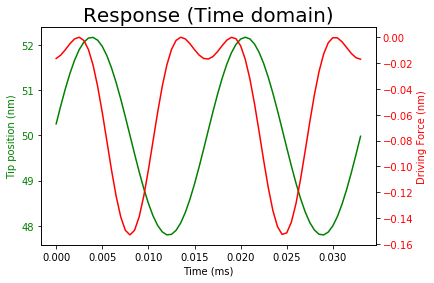

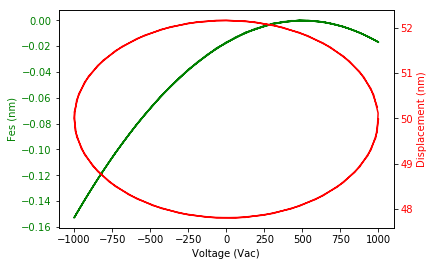

In [46]:
k=int(round(2*pnts_p_period))
plt.figure(1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t[:k]*1000,TipPos[-k:]*1e9, 'g-')
ax1.tick_params(axis='y', labelcolor='g')
ax2.plot(t[:k]*1000,Fd[-k:]*1e9, 'r-')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Tip position (nm)', color='g')
ax2.set_ylabel('Driving Force (nm)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Response (Time domain)', fontsize = 20)


k=int(round(2*pnts_p_period))

plt.figure(1)
fig, ax1 = plt.subplots()
ax1.plot(Vac_vec[-k:]*1000,Fd[-k:]*1e9, 'g-',label='Force')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xlabel('Voltage (Vac)')
ax1.set_ylabel('Fes (nm)', color='g')
ax2 = ax1.twinx()
ax2.plot(Vac_vec[-k:]*1000,TipPos[-k:]*1e9, 'r-',label='Displacement')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xlabel('Voltage (Vac)')
ax2.set_ylabel('Displacement (nm)', color='r')



**Now lets do the same thing but this time plot the tip voltage vs the tip displacement. Notice now we have a straight line**

Text(0,0.5,'Displacement (nm)')

<Figure size 432x288 with 0 Axes>

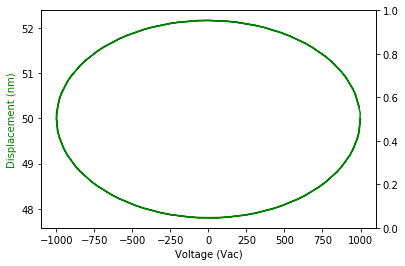

In [47]:
k=int(round(2*pnts_p_period))

plt.figure(1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(Vac_vec[-k:]*1000,TipPos[-k:]*1e9, 'g-')
#ax2.plot(t[-k:]*1000,Fd[-k:]*1e9, 'r-')
ax1.set_xlabel('Voltage (Vac)')
ax1.set_ylabel('Displacement (nm)', color='g')